In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
import numpy as np

In [8]:
from keras.models import model_from_json
# load json and create model
json_file = open('/home/madhumadi/sd/srcnn_tjf_ds_full_elevation_1_e_1000/srcnn_pred_srcnn_tjf_ds_full_elevation_1_e_1000_16_06.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/home/madhumadi/sd/srcnn_tjf_ds_full_elevation_1_e_1000/srcnn_weights_srcnn_tjf_ds_full_elevation_1_e_1000_16_06.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error',optimizer='adam')

Loaded model from disk


In [9]:

data_size=-1 #train+test
batch_size=100 # Size of each batch
n_epochs=1000
use_elevation=1
patience=100
if data_size== -1:
    ds='full'
else:
    ds=data_size


In [10]:
import xarray as xr
y=xr.open_dataset('/home/madhumadi/sd/nc_files/obs_1920_to_2005_no_leap.nc')['precipitation (mm)'].sel(time=slice('1950-01-01','2005-12-31')).fillna(0)


In [11]:
y.shape

(20440, 129, 135)

In [12]:
t=xr.open_dataset('/home/madhumadi/bcsd_bcsrcnn/CESM/no_ties_parameters_bcsd_1950_1980.nc')
t

<xarray.Dataset>
Dimensions:         (lat: 117, lon: 118, time: 11315)
Coordinates:
  * lon             (lon) float64 68.0 68.25 68.5 68.75 ... 96.75 97.0 97.25
  * time            (time) object 1950-01-01 00:00:00 ... 1980-12-31 00:00:00
  * lat             (lat) float64 8.25 8.5 8.75 9.0 ... 36.5 36.75 37.0 37.25
Data variables:
    bcsd_1950_1980  (time, lat, lon) float64 ...

In [13]:
model_temp=t['bcsd_1950_1980'].fillna(0)

In [14]:
model_t=model_temp.sel(time=~((model_temp.time.dt.month == 2) & (model_temp.time.dt.day == 29)))

In [15]:
model_t.shape

(11315, 117, 118)

In [16]:
print(model_t.time.values[0])

1950-01-01 00:00:00


In [17]:
print(model_t.time.values[-1])

1980-12-31 00:00:00


In [18]:
model=model_t.sel(time=slice('1950-01-01','1980-12-31'))

In [19]:
model

<xarray.DataArray 'bcsd_1950_1980' (time: 11315, lat: 117, lon: 118)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]])
Coordinates:
  * lon      (lon) float64 68.0 68.25 68.5 68.75 69.0 ... 96.5 96.75 97.0 97.25
  * time     (time) object 1950-01-01 00:00:00 ... 1980-12-31 00:00:00
  * lat      (lat) float64 8.25 8.5 8.75 9.0 9.25 ... 36.5 36.75 37.0 37.25

In [20]:
mask=xr.where(xr.open_dataset('nc_files/obs_1920_to_2005_no_leap.nc')['precipitation (mm)'][0]>=0,1,np.nan)

In [21]:
mask.plot()

In [22]:
temp=model.interp_like(mask)

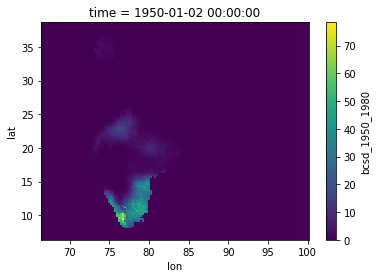

In [23]:
temp[1].fillna(0).plot()

In [24]:

x=temp.fillna(0)
train_images=np.asarray(x)

In [25]:
train_images[0].shape

(129, 135)

In [26]:

if use_elevation==1:
    import xarray as xr
    from numpy import *
    a='/home/madhumadi/sd/nc_files/india_masked_ele_interp.nc'
    elevation=xr.open_dataset(a)
    elevation_temp2=elevation.interp(lon=np.arange(66.5,100.0,0.25), lat=np.arange(6.5,38.5,0.25))

    felev_temp=np.asarray(elevation_temp2['Band1']).reshape([128,134])

    def fill_na(x, fillval=0):
        where_are_NaNs = isnan(x)
        x[where_are_NaNs] = fillval
        return x
    felev_te=fill_na(felev_temp)
    felev=((felev_te-np.min(felev_te))/(np.max(felev_te)-np.min(felev_te)))

    train_images.shape
    p1=[]
    for i in range(len(train_images)):
        p2=np.asarray([train_images[i,0:128,0:134],felev*50])
        p1.append(p2)
    p3=np.asarray(p1)
    print(p3.shape)
    resu=p3.transpose(0,2,3,1)
    print(resu.shape)


(11315, 2, 128, 134)
(11315, 128, 134, 2)


In [27]:
resu.shape

(11315, 128, 134, 2)

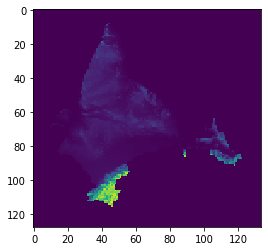

In [28]:
import pylab as plt
plt.imshow(resu[0,:,:,1])

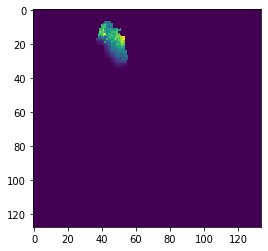

In [29]:
plt.imshow(resu[0,:,:,0])

In [30]:
predictions=loaded_model.predict(resu)

In [31]:
predictions.shape

(11315, 128, 134, 1)

In [40]:
name_of_variable='CESM_bcsrcnn_1950_1980'

In [41]:
predict=predictions.reshape([-1,128,134])
print('saving')
xr_object = xr.Dataset({name_of_variable: (('time', 'lat', 'lon'), predict)},coords={"lat": np.arange(6.5,38.5,0.25), "lon":np.arange(66.5,100.0,0.25), "time": xr.cftime_range('1950-01-01','1980-12-31', calendar='noleap')})



saving


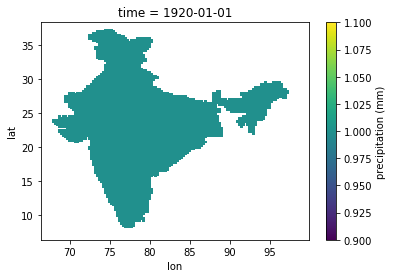

In [42]:
mask[0:128,0:134].plot()

In [43]:
xr_object[name_of_variable].max()

<xarray.DataArray 'CESM_bcsrcnn_1950_1980' ()>
array(1663.4962, dtype=float32)

In [44]:
masked_xr=xr_object*mask[0:128,0:134]

In [45]:
masked_xr

<xarray.Dataset>
Dimensions:                 (lat: 128, lon: 134, time: 11315)
Coordinates:
  * lat                     (lat) float64 6.5 6.75 7.0 7.25 ... 37.75 38.0 38.25
  * lon                     (lon) float64 66.5 66.75 67.0 ... 99.25 99.5 99.75
  * time                    (time) object 1950-01-01 00:00:00 ... 1980-12-31 00:00:00
Data variables:
    CESM_bcsrcnn_1950_1980  (time, lat, lon) float64 nan nan nan ... nan nan nan

In [46]:
path='/home/madhumadi/bcsd_bcsrcnn/CESM/'

In [47]:
path+name_of_variable+'.nc'

'/home/madhumadi/bcsd_bcsrcnn/CESM/CESM_bcsrcnn_1950_1980.nc'

In [48]:
masked_xr[name_of_variable].clip(0).to_netcdf(path+name_of_variable+'.nc')

In [49]:
pwd

'/home/madhumadi/sd'

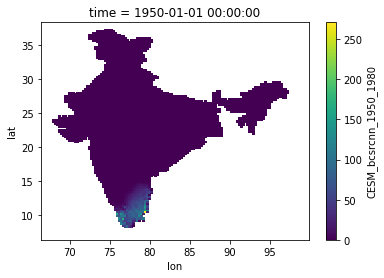

In [50]:
masked_xr[name_of_variable][0].clip(0).plot()

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras



In [ ]:


import numpy as np
import xarray as xr
import pylab as plt


# In[3]:


data_size=-1 #train+test
batch_size=100 # Size of each batch
n_epochs=1
use_elevation=1
patience=50
if data_size== -1:
    ds='full'
else:
    ds=data_size


# In[4]:


name='bcsd_ds_{data_size}_elevation_{use_elevation}_e_{n_epochs}'.format(data_size=ds,use_elevation=use_elevation,n_epochs=n_epochs)
name


# In[5]:

#x=xr.open_dataset('cliped_gcm_1920_to_2005.nc')['__xarray_dataarray_variable__'].fillna(0)
data=xr.open_dataset('/home/madhumadi/sd/nc_files/observation_bcsd_op_1920_2005.nc')
y=data['precipitation (mm)'].fillna(0)


# In[6]:
x=data['bias_corrected_gcm'].fillna(0)
train_images=np.asarray(x)
train_labels=np.asarray(y)

mask=xr.where(y[0]>=0,1,np.nan)
# In[7]:


np.random.seed(seed=0)


# In[8]:


import xarray as xr
a='/home/madhumadi/sd/nc_files/india_masked_ele_interp.nc'
elevation=xr.open_dataset(a)
elevation['Band1'].plot()
#felev_temp=np.asarray(elevation['Band1']).reshape([117,118])


# In[46]:


elevation_masked=(elevation['Band1'].fillna(0))*mask


# In[47]:


elevation_masked.plot()


# In[48]:


elevation1=elevation_masked.dropna(dim='lat',how='all')
elevation=elevation1.dropna(dim='lon',how='all')
felev_temp=np.asarray(elevation).reshape([117,118])


# In[49]:



from numpy import *
def fill_na(x, fillval=0):
    where_are_NaNs = isnan(x)
    x[where_are_NaNs] = fillval
    return x
felev_te=fill_na(felev_temp)


# In[50]:


#felev.shape


felev=((felev_te-np.min(felev_te))/(np.max(felev_te)-np.min(felev_te)))

train_images.shape
p1=[]
for i in range(len(train_images)):
    p2=np.asarray([train_images[i],felev*50])
    p1.append(p2)
p3=np.asarray(p1)
resu=p3.transpose(0,2,3,1)



# In[9]:


import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation
from keras.layers.normalization import BatchNormalization
import numpy as np
import pickle
from keras.models import model_from_json
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import h5py
import matplotlib.pyplot as plt
from keras import backend as K
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


# In[10]:


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))


# In[11]:


from keras.models import model_from_json
# load json and create model
json_file = open('/home/madhumadi/sd/srcnn_tjf_ds_full_elevation_1_e_1000/srcnn_pred_srcnn_tjf_ds_full_elevation_1_e_1000_16_06.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/home/madhumadi/sd/srcnn_tjf_ds_full_elevation_1_e_1000/srcnn_weights_srcnn_tjf_ds_full_elevation_1_e_1000_16_06.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error',optimizer='adam')

# In[12]:


model.summary()


# In[13]:


terNAN=keras.callbacks.TerminateOnNaN()
tensorboard = TensorBoard(log_dir='./{}/logs{}'.format(name,name), histogram_freq=0,write_graph=True, write_images=False)
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau,CSVLogger
csv_logger = CSVLogger('./{}/training{}.log'.format(name,name))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9,patience=patience, min_lr=0.0001,verbose=1)
mc = ModelCheckpoint('./{}/best_model.h5'.format(name,name), monitor='loss', mode='auto', verbose=0, save_best_only=False)
if use_elevation==1:
    history=model.fit(resu, train_labels.reshape([-1,117,118,1]),batch_size=batch_size, epochs= n_epochs, validation_split = 0.2, verbose=1,callbacks=[es,csv_logger,tensorboard,reduce_lr, mc,terNAN])
else:
    history=model.fit(a.reshape([-1,117,118,1]), b.reshape([-1,117,118,1]),batch_size=batch_size, epochs= n_epochs, validation_split = 0.2, verbose=1,callbacks=[es,csv_logger,tensorboard,reduce_lr, mc,terNAN])


# In[14]:




model_json = model.to_json()
with open("./{}/srcnn_pred_{}_16_06.json".format(name,name), "w") as json_file:
    json_file.write(model_json)
model.save_weights("./{}/srcnn_weights_{}_16_06.h5".format(name,name))
print("Saved model to disk")

def his():
    loss_history=history.history['loss']
    val_loss_history=history.history['val_loss']
    return loss_history,val_loss_history


with open('./{}/srcnn_16_06_history{}.pkl'.format(name,name), 'wb') as fp:
    pickle.dump(his(), fp) 


# In[ ]:






